# Segmentation of Medical Scans using Variational VAE's - Part 2/3
This series of notebooks enables reproduceability of our final models and testing results.

The second notebook goes through the process of creating, training and tuning a variational autoencoder to be able to accurately represent our data in a lower-dimensional latent space.

We import some necessary libraries, and check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large. We setup up some global constants.

In [1]:
# For ML
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.optim as optim

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt

# For monitoring resource-usage and progress.
from timeit import default_timer as timer
import psutil
from os.path import join

# Our own utility functions, constants and classes.
from utility import CT_Dataset, list_checkpoints, save_checkpoint, load_model, load_optimizer, superimpose, draw

# Our own DL models.
from models import VAEModel, Conv, ConvTranspose


# Paths.
root_dir = '../' # Relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'prep_data')
losses_dir = join(root_dir, 'losses')
models_dir = join(root_dir, 'saved_models')
checkpoint_dir = join(root_dir, 'checkpoints')


# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce GTX 1070
CUDA version: 11.7
RAM: 16.74GB


We create a function, which will split a dataset and create appropriate dataloaders.

In [2]:
def make_loaders(data, batch_size):
    N = len(data); N_t = int(0.9*N); N_d = N - N_t
    train_data, dev_data = D.random_split(data, [N_t, N_d])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

We define the variational encoder architecture as a pytorch module (see VAEModel.py).

We define a custom loss function, which combines binary-cross-entropy loss and Kullback–Leibler divergence. We also define a training routine for a single epoch, i.e. a full round of training data, as well as an evaluation routine.

In [3]:
def loss_fn(batch, recon, mu, log_var):
    recon_loss = nn.BCELoss(reduction='mean')
    kld = (-0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()))
    return recon_loss(recon, batch) + 0.1 * kld
    
def train_epoch(model, optimizer, train_loader):
    model.train()
    losses = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = model(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        losses += loss.item()   
    return losses / len(train_loader) # Average loss.

def evaluate(model, dev_loader):
    model.eval()
    losses = 0

    for data in dev_loader:
        x = data[0].to(device)
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        losses += loss.item()

    return losses / len(dev_loader)

We create an instance of the CT_Dataset, specifying the organ, on which we wish to train our model. This set is passed onto the dataloaders. Be careful with running this, as the dataset variable will take up a lot of space in RAM.

In [4]:
resolution = 2**8
batch_size = 32;
dataset = CT_Dataset(prep_data_dir, 'lung', resolution)
train_loader, dev_loader = make_loaders(dataset, batch_size)

# Checking if the output dimensions are correct.
image, label = dataset.__getitem__(1)
print(np.shape(image))
batch = next(iter(train_loader))
print(np.shape(batch[0]))

torch.Size([1, 256, 256])
torch.Size([32, 1, 256, 256])


We use our previously defined class to create an instance of our model. We specify the optimizer, as well as a learning rate scheduler.

In [5]:
model = VAEModel(base=16); model = model.to(device)
lr = 4e-3
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

Finally, we train our model.

In [6]:
total_epochs = 0 # CHANGE TO TRAIN.
use_checkpoint = False; record_checkpoint = False

train_losses = []; dev_losses = []; lrs = []

# Load last checkpoint, if present.
if use_checkpoint and len(list_checkpoints(checkpoint_dir)) != 0:
    model = load_model(checkpoint_dir, model)
    optimizer = load_optimizer(checkpoint_dir, optimizer)
    trained_epochs = max(list_checkpoints(checkpoint_dir))
    print('Training from epoch ' + str(trained_epochs))
else:
    print('Training from scratch:')
    trained_epochs = 0;

try:
    for epoch in range(trained_epochs+1, total_epochs+1):
        lrs.append(optimizer.param_groups[0]['lr'])
        start_time = timer()
        train_loss = train_epoch(model, optimizer, train_loader)
        train_losses.append(train_loss)
        end_time = timer()
        dev_loss = evaluate(model, dev_loader)
        dev_losses.append(dev_loss)
        scheduler.step()

        trained_epochs = epoch
        
        print((f"Epoch {epoch}:, Train-loss: {train_loss:.4f}, Dev-loss: {dev_loss:.4f}, "f"Epoch-time = {(end_time - start_time):.3f}s"))

        if epoch % 5 == 0 and record_checkpoint:
            save_checkpoint(checkpoint_dir, trained_epochs, model, optimizer)
        
    print('Training completed.')  

except KeyboardInterrupt:
    print('Manually stopped.')
    save_checkpoint(checkpoint_dir, trained_epochs, model, optimizer)

print('Checkpoint saved.')

Training from scratch:
Training completed.
Checkpoint saved.


We save the trained VAE model along with loss metrics.

In [7]:
# CAREFUL NOT TO OVERWRITE.
#torch.save(model, '../saved_models/' + 'vae_model.pt') 
#torch.save(train_losses, '../losses/' + 'vae_train_losses.pt')
#torch.save(dev_losses, '../losses/' + 'vae_dev_losses.pt')

Now that the model is trained, we can load it in anywhere.

In [ ]:
model = torch.load(join(models_dir, 'vae_model.pt'))

And we can check if the VAE is able to reconstruct an approximation of the orignal image from its feature vector z. Simply run the block below to try a different image.

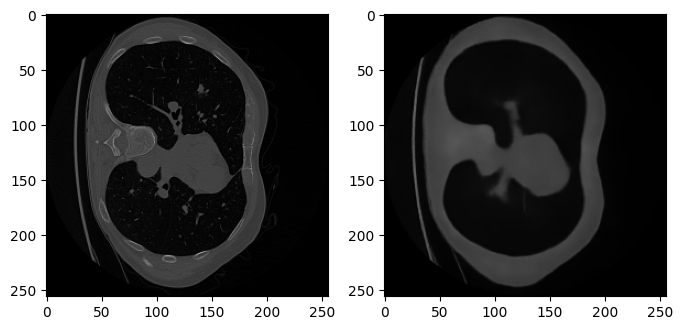

In [13]:
model.eval() # Tell model to not update weights.

original = next(iter(dev_loader))[0][0].view(1, 1, 256, 256).to(device)
reconstruction = model.forward(original)[0]

draw(original.cpu().view(1,256,256), 
     reconstruction.cpu().view(1,256,256))

We plot the loss metrics for the last 45 epochs.

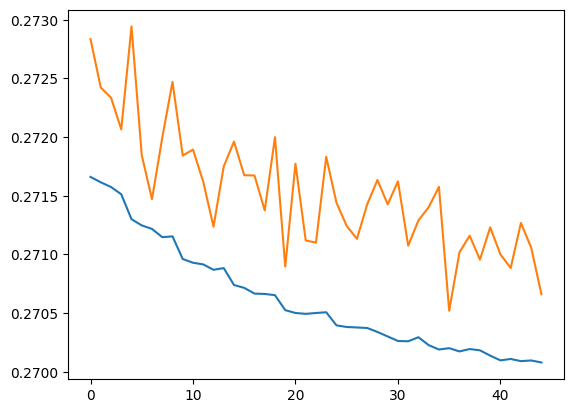

In [9]:
plt.plot(np.array(torch.load(join(losses_dir, 'vae_train_losses.pt'))))
plt.plot(np.array(torch.load(join(losses_dir, 'vae_dev_losses.pt'))))